In [1]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 18.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import math
import openpyxl
import matplotlib.pyplot as plt

In [3]:
file_path = "data/ESG_raw_data_07_02.xlsx"
file_sect = "data/secteurs.csv"
corresp_secteurs = pd.read_csv(file_sect, sep=";")
data = pd.read_excel(file_path)
data = data.join(corresp_secteurs.set_index('primary_industry'), on = "primary_industry")

In [4]:
secteurs = pd.unique(data["secteur"])

In [5]:
variables_env = ["scope_1", "scope_2", "scope_3", "waste_production", "waste_recycling", 
                 "water_consumption", "water_withdrawal", "energy_consumption"]

for v in variables_env :
    data[v] = data[v]/data["employees"]

## Scope 1

On va analyser l'hétérogénéité intra-sectorielles pour le scope 1.

In [21]:
def visualisation(scope, sec, per) :
    df = data.loc[data["secteur"] == sec]
    df = df.groupby('company_id')[scope].mean().reset_index()
    mean = df[scope].mean()
    var = df[scope].var()
    list_companies = df[df[scope] >= mean*(1 + per)]
    list_companies = list_companies[list_companies[scope] <= mean*(1 - per)]
    df[scope] = df[scope]/np.sqrt(var)
    df.hist(column = scope, bins = 100)


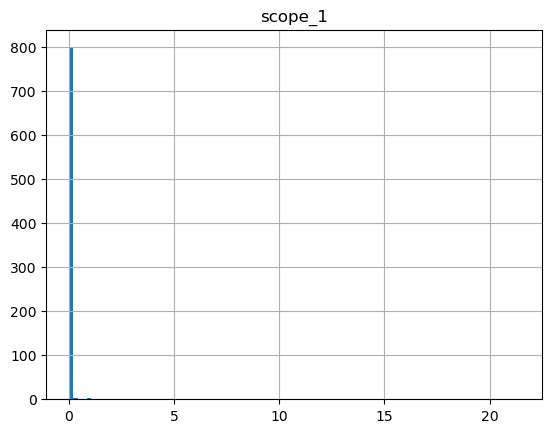

In [22]:
visualisation("scope_1", secteurs[0], 1)